In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize  import curve_fit
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
import seaborn as sns

# Inputs and reading in of all the files

In [2]:
# Frequently changing 
filename= 'N6_clpP_replicate2'
tmt= pd.read_csv('N6_clpP_replicate2.csv')

wide_isolation_use= 'no'

if wide_isolation_use=='yes': 
    wide_isolation= pd.read_csv('mgupta_1633123563_n12_replicate1_meera.csv')
    
max_intensity_peptide_only_use= 'no'
choice_value_input= 'm'




extra_time=0
time_array= np.array([0, 98, 216, 404, 546, 749, 1336, 1677])

Dilution_half_life_hrs= 6.0
Cfactor= 100



In [3]:
# Table for number of nitrogen per amino acid
nitrogen_number= pd.read_excel('../../E.coli resources/amino_acid.xlsx')

# # # Entry to gene names and subcellular location for protein ids 
tmt5_location= pd.read_csv('../../E.coli resources/MG1655_gene_names_location.csv')

# Commonly used functions

In [4]:
def header_splitter(x):
    if(x.count('|')==2):
         y=x.split('|')[1]  # takes only number as an identifier
    elif (x.count('|')==1):
         y=x.split('|')[0] 
    else:
         y=x
    return y

def sub_cellular(choice, df): 
    if choice =='o': 
        df_return = df[(df['Subcellular location [CC] 1'].str.contains('outer')==True) & (df['Subcellular location [CC] 1'].str.contains('membrane')==True) ]
    elif choice =='p': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('Periplasm')==True]
    elif choice=='c': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('Cytoplasm')==True]
    elif choice=='m': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('membrane')==True]
    elif choice=='i': 
        df_return = df[(df['Subcellular location [CC] 1'].str.contains('outer')==False) & (df['Subcellular location [CC] 1'].str.contains('membrane')==True) ]
    return (df_return)



def normalized_array_for_plotting(dilution_half_life_h, active_degradation_rate_per_min, nitrogen_number): 
    D=np.log(2)/ dilution_half_life_h/60
    Dt= D+active_degradation_rate_per_min
    n=nitrogen_number
    term1= Dt
    term2= n*Cfactor*D
    constant= term1-term2
    final= (term1*np.exp(-term2*time_array)-term2*np.exp(-term1*time_array))/constant
    sum_final=final.sum()
    final1= final/sum_final
    return final1


def cosine_distance_calculator(x): 
     return (1-cosine(x, normalized_array_for_plotting(Dilution_half_life_hrs, 0, 12)))


def vector_sum(x): 
    i=0 
    array_new= []
    while i<(len(x)-1): 
        array_new.append(np.sum(x[i:i+8])) 
        i=i+8
    #print array_new
    return np.repeat(array_new,8)

def degradation(X, a):
    kd= np.log(2)/ (Dilution_half_life_hrs*60)
    t,n= X
    c= Cfactor
    vector1= (a*np.exp(-n*t*c*kd)- n*c*kd*np.exp(-a*t))
    vector2= vector_sum(vector1)
    vector3= vector1/vector2
    return vector3

def continuous_degrading_curve(Dilution_half_life_h, active_degradation_rate_per_h, nitrogen_number):
    time_array1=np.linspace(0,50,100)
    D=np.log(2)/ Dilution_half_life_h
    Dt= D+active_degradation_rate_per_h
    n=nitrogen_number
    term1= Dt
    term2= n*D
    constant= term1-term2
    final= (term1*np.exp(-term2*time_array1)-term2*np.exp(-term1*time_array1))/constant
    return final

#### Initial Preprocessing

In [5]:

tmt1= tmt[tmt['Parsimony'].isnull()==False]

tmt2= tmt1[tmt1['Protein ID'].str.contains("#")==False]

tmt3= tmt2[tmt2['Protein ID'].str.contains('contaminant')==False]
 

# For peptides that are chosen again and again chosse the one with the max signal 

tmt3['sum_signal']= tmt3['AYnmin1Pmin1 Sn']+tmt3['BYnmin1P0 Sn']+tmt3['CYnmin1Pplus1 Sn']+tmt3['DYnmin1Pplus2 Sn']+tmt3['EYnmin1Pplus3 Sn']+tmt3['FYnmin1Pplus4 Sn']+tmt3['GYnmin1Pplus5 Sn']+tmt3['HYnmin1Pplus6 Sn']+tmt3['IYnmin1Pplus7 Sn']+tmt3['JYnmin1Pplus8 Sn']+tmt3['KYnmin1Pplus9 Sn']+tmt3['LYnmin1Pplus10 Sn']
tmt4= tmt3[tmt3['sum_signal']>40]

tmt4['sum_ratios']= tmt4['ratios1']+tmt4['ratios2']+tmt4['ratios3']+tmt4['ratios4']+tmt4['ratios5']+tmt4['ratios6']+tmt4['ratios7']+tmt4['ratios8']
tmt5= tmt4[tmt4['sum_ratios']!=0].dropna(subset=['ratios1', 'ratios2', 'ratios3', 'ratios4', 'ratios5', 'ratios6', 'ratios7', 'ratios8'])

# Oxidised methionines 
tmt6=tmt5[tmt5['Peptide'].str.contains('\*')==False]


# Missed cleaved peptides are also thrown out
tmt6['strip_peptides']= tmt6['Peptide'].map(lambda x: x.split('.')[1])
tmt6['strip_peptides2']= tmt6['strip_peptides'].map(lambda x: x[:-1])
tmt6['Peptide_length']= tmt6['strip_peptides'].map(lambda x: len(x))
tmt7= tmt6[tmt6['strip_peptides2'].str.contains('K')==False]
tmt8= tmt7[tmt7['strip_peptides2'].str.contains('R')==False]

# check which all charges are present 
tmt9= tmt8[tmt8['z']==2]


# filtering based on the monisotopic peak masses 
tmt9['theoretical_mass_Da']=tmt9['z']*tmt9['Theo m/z']
tmt9['expected_da_less']= tmt9['theoretical_mass_Da']-0.1
tmt9['expected_da_more']= tmt9['theoretical_mass_Da']+0.1

tmt9['Isolation_mass_Da']= tmt9['z']*tmt9['Isolation m/z']
tmt10= tmt9[(tmt9.Isolation_mass_Da>tmt9.expected_da_less)&(tmt9['Isolation_mass_Da']<=tmt9['expected_da_more'])]



# only get that particular instance of a peptide that has maximum signal 
if max_intensity_peptide_only_use=='yes': 
    df_final= tmt10.sort_values(by=['Peptide','sum_signal'],ascending=False).drop_duplicates(keep='first',subset=['Peptide'])
else: 
    df_final= tmt10


    
print (tmt.shape, tmt1.shape, tmt2.shape, tmt3.shape, tmt4.shape, tmt5.shape , tmt6.shape, tmt7.shape, tmt8.shape,tmt9.shape, tmt10.shape, df_final.shape)    
print ('No of proteins %d' %(df_final.groupby(['Protein ID']).ngroups)) 

C:\Users\gupta\AppData\Local\Temp\ipykernel_9608\1173484246.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmt3['sum_signal']= tmt3['AYnmin1Pmin1 Sn']+tmt3['BYnmin1P0 Sn']+tmt3['CYnmin1Pplus1 Sn']+tmt3['DYnmin1Pplus2 Sn']+tmt3['EYnmin1Pplus3 Sn']+tmt3['FYnmin1Pplus4 Sn']+tmt3['GYnmin1Pplus5 Sn']+tmt3['HYnmin1Pplus6 Sn']+tmt3['IYnmin1Pplus7 Sn']+tmt3['JYnmin1Pplus8 Sn']+tmt3['KYnmin1Pplus9 Sn']+tmt3['LYnmin1Pplus10 Sn']
C:\Users\gupta\AppData\Local\Temp\ipykernel_9608\1173484246.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

(409464, 306) (36084, 306) (36055, 306) (35893, 307) (33766, 308) (33102, 308) (27658, 311) (27508, 311) (26635, 311) (26635, 315) (25350, 315) (25350, 315)
No of proteins 2331


C:\Users\gupta\AppData\Local\Temp\ipykernel_9608\1173484246.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmt6['strip_peptides']= tmt6['Peptide'].map(lambda x: x.split('.')[1])
C:\Users\gupta\AppData\Local\Temp\ipykernel_9608\1173484246.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmt6['strip_peptides2']= tmt6['strip_peptides'].map(lambda x: x[:-1])
C:\Users\gupta\AppData\Local\Temp\ipykernel_9608\1173484246.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [6]:
# Count the number of nitrogen in a peptide
df_final['Nitrogens']=0
for index,ni in nitrogen_number[['Amino acid','Nitrogen']].iterrows():
    df_final['Nitrogens'] += df_final['strip_peptides'].str.count(ni['Amino acid'])*ni['Nitrogen']


C:\Users\gupta\AppData\Local\Temp\ipykernel_9608\3572796094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Nitrogens']=0
C:\Users\gupta\AppData\Local\Temp\ipykernel_9608\3572796094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Nitrogens'] += df_final['strip_peptides'].str.count(ni['Amino acid'])*ni['Nitrogen']


In [7]:
df_final1 = df_final[['Protein ID', 'Peptide','ScanF','ratios1', 'ratios2', 'ratios3', 'ratios4','ratios5', 'ratios6', 'ratios7','ratios8', 'Nitrogens', 'sum_signal']].reset_index()

if wide_isolation_use=='no': 
    array= np.repeat(1,8)
    number1= array[0]
    number2= array[1]
    number3= array[2]
    number4= array[3]
    number5= array[4]
    number6= array[5]
    number7= array[6]
    number8= array[7]
else: 
    array= wide_isolation
    number1= array['0'][0]
    number2= array['0'][1]
    number3= array['0'][2]
    number4= array['0'][3]
    number5= array['0'][4]
    number6= array['0'][5]
    number7= array['0'][6]
    number8= array['0'][7]


df_final1['0_med']= df_final1['ratios1'].astype(float)/ number1
df_final1['1_med']= df_final1['ratios2'].astype(float)/ number2
df_final1['2_med']= df_final1['ratios3'].astype(float)/ number3
df_final1['3_med']= df_final1['ratios4'].astype(float)/ number4
df_final1['4_med']= df_final1['ratios5'].astype(float)/ number5
df_final1['5_med']= df_final1['ratios6'].astype(float)/ number6
df_final1['6_med']= df_final1['ratios7'].astype(float)/ number7
df_final1['7_med']= df_final1['ratios8'].astype(float)/ number8

df_final1['sum_med']= df_final1['0_med'].astype(float)+ df_final1['1_med']+df_final1['2_med']+df_final1['3_med']+df_final1['4_med']+df_final1['5_med']+df_final1['6_med']+df_final1['7_med']
df_final1['0_med_ave']= df_final1['0_med'].astype(float)/ df_final1['sum_med']
df_final1['1_med_ave']= df_final1['1_med'].astype(float)/ df_final1['sum_med']
df_final1['2_med_ave']= df_final1['2_med'].astype(float)/ df_final1['sum_med']
df_final1['3_med_ave']= df_final1['3_med'].astype(float)/ df_final1['sum_med']
df_final1['4_med_ave']= df_final1['4_med'].astype(float)/ df_final1['sum_med']
df_final1['5_med_ave']= df_final1['5_med'].astype(float)/ df_final1['sum_med']
df_final1['6_med_ave']= df_final1['6_med'].astype(float)/ df_final1['sum_med']
df_final1['7_med_ave']= df_final1['7_med'].astype(float)/ df_final1['sum_med']


df_final1['Entry']= df_final1['Protein ID'].apply(header_splitter)
df_final2= df_final1.merge(tmt5_location[['Entry','Gene names ', 'Subcellular location [CC] 1', 'membrane_confirmation']], on='Entry', how='left')
df_final2.head()

index            Protein ID           Peptide  ScanF  ratios1  ratios2  \
0     21  sp|P09373|PFLB_ECOLI      K.TGNTPDGR.R    196  0.33536  0.29811   
1     32  sp|P04994|EX7L_ECOLI     R.ANITLYEPR.G  10005  0.28036  0.21142   
2     43  sp|P22259|PCKA_ECOLI  R.EDGTIDFDDGSK.T  10008  0.28806  0.21628   
3     76  sp|P0A9K3|PHOL_ECOLI    R.SLYVDTAPMR.G  10030  0.36123  0.23916   
4    109  sp|P0A9J8|PHEA_ECOLI       K.ISALDEK.L  10077  0.35396  0.25106   

   ratios3  ratios4   ratios5   ratios6  ...  2_med_ave  3_med_ave  4_med_ave  \
0  0.18691  0.12936  0.049847  0.000130  ...   0.186910   0.129360   0.049847   
1  0.19371  0.12504  0.091581  0.063589  ...   0.193709   0.125040   0.091581   
2  0.15566  0.11963  0.056262  0.053625  ...   0.155660   0.119630   0.056262   
3  0.17844  0.12304  0.055428  0.034761  ...   0.178440   0.123040   0.055428   
4  0.18655  0.10797  0.060331  0.031337  ...   0.186549   0.107969   0.060331   

   5_med_ave  6_med_ave  7_med_ave   Entry  Gene names   \
0   0.000130   0.000139   0.000142  P09373         pflB   
1   0.063589   0.024157   0.010146  P04994         xseA   
2   0.053625   0.054671   0.055811  P22259         pckA   
3   0.034761   0.004806   0.003133  P0A9K3         ybeZ   
4   0.031337   0.005714   0.003084  P0A9J8         pheA   

   Subcellular location [CC] 1  membrane_confirmation  
0                   Cytoplasm.                  False  
1                   Cytoplasm.                  False  
2                   Cytoplasm.                  False  
3                   Cytoplasm                   False  
4                   Cytoplasm                   False  

[5 rows x 35 columns]

# Look at the data

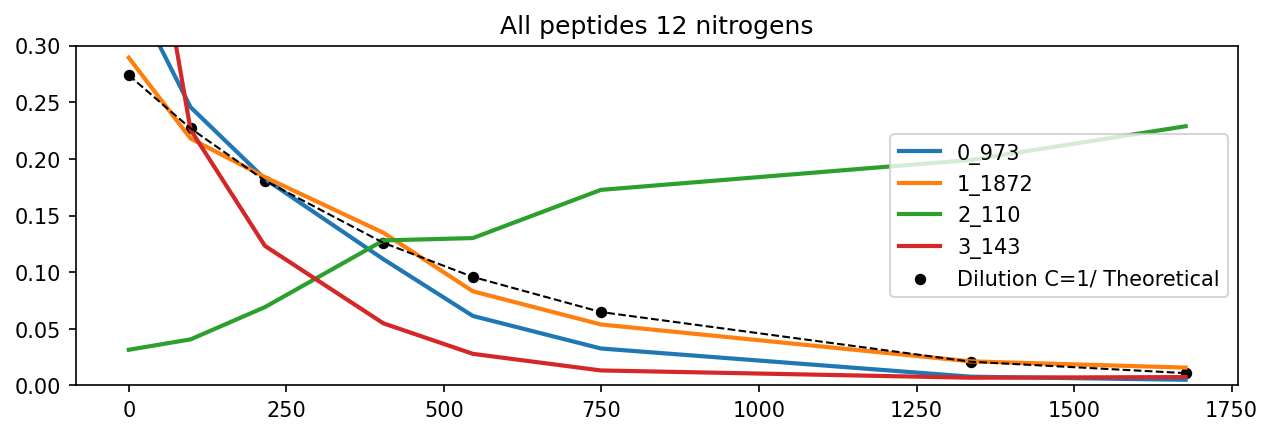

In [8]:
# Kmeans clustering of the data 
# Kmeans clustering of the membrane proteins

plt.figure(figsize=(10,3),dpi=150)

nitrogen_test= 12
temporary=df_final2[df_final2['Nitrogens']==nitrogen_test]

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']].dropna()
kmeans= KMeans(n_clusters=4, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []
i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    cluster_number.append(len(kmeans.labels_[kmeans.labels_==i]))
    
    i=i+1
    
plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution C=1/ Theoretical')
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.3])
plt.title('All peptides %d nitrogens'%(nitrogen_test))
plt.legend()
plt.show()

# median all... median membrane and cytoplasm and periplasm 

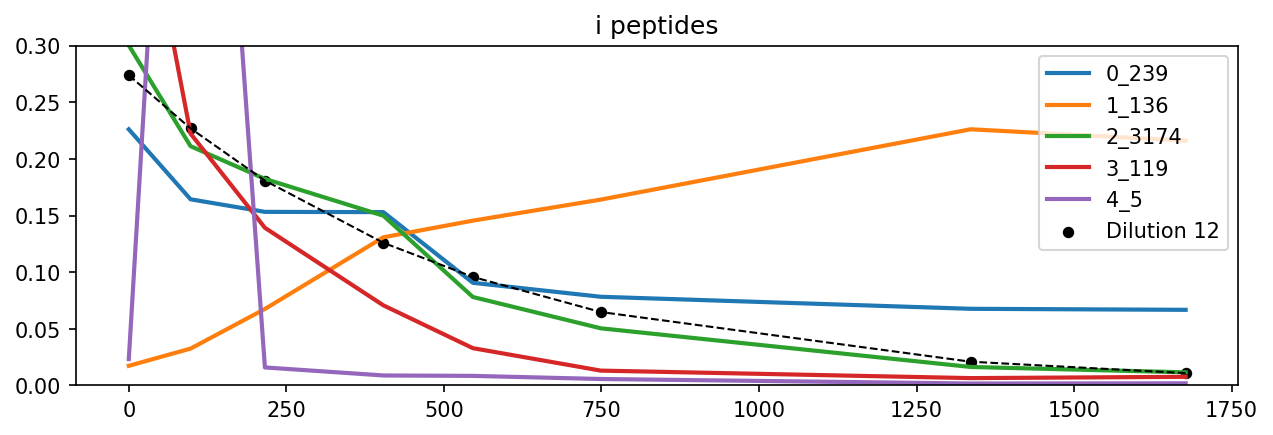

In [9]:
plt.figure(figsize=(10,3),dpi=150)
choice_value='i'

temporary=sub_cellular(choice_value, df_final2)

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']].dropna()
no_clusters= 5
kmeans= KMeans(n_clusters=no_clusters, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []

i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    i=i+1

plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution %d'%(nitrogen_test))
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.3])
plt.title('%s peptides'%(choice_value))
plt.legend()
plt.show()

## First iteration for selecting membrane peptides to normalize. 

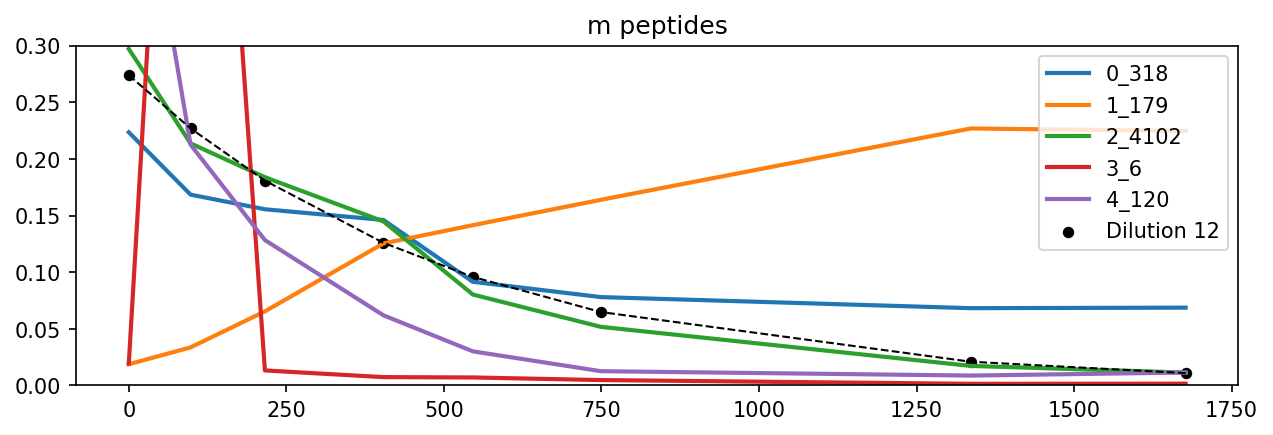

In [10]:
plt.figure(figsize=(10,3),dpi=150)
choice_value=choice_value_input

temporary=sub_cellular(choice_value, df_final2).dropna(subset= ['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave'])

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']]
no_clusters= 5
kmeans= KMeans(n_clusters=no_clusters, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []
cosine_distance=[]
i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    cluster_number.append(len(kmeans.labels_[kmeans.labels_==i]))
    cosine_distance.append(cosine_distance_calculator(kmeans.cluster_centers_[i]))
    i=i+1

membrane_peptides_kmeans_clusters=pd.DataFrame({'Labels': np.arange(0,no_clusters), 'cluster_number': cluster_number, 'cosine_distance': cosine_distance})
temporary['kmeans_labels']= kmeans.labels_
membrane_peptides_kmeans= temporary

plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution %d'%(nitrogen_test))
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.3])
plt.title('%s peptides'%(choice_value))
plt.legend()
plt.show()


C:\Users\gupta\AppData\Local\Temp\ipykernel_9608\2215491326.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temporary['cosine_distance']= temporary[med_ave_cols].apply (cosine_distance_calculator, axis=1)


Cluster label that is excluded from normalization 4


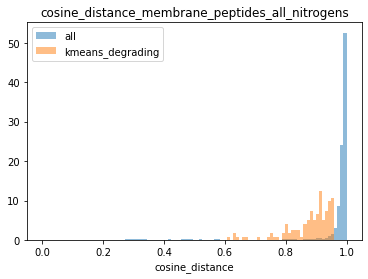

52
All membrane peptides 4725, Membrane_peptides_for_norm 3892


In [11]:
# Asking the cosine distance with a 12 numbered nitrogen

temporary=sub_cellular(choice_value, df_final2)


# All membrane peptides
med_ave_cols= [col for col in temporary.columns if 'med_ave' in col]
temporary['cosine_distance']= temporary[med_ave_cols].apply (cosine_distance_calculator, axis=1)

# Only some membrane peptides with a particular number of nitrogens to test if thse have poor cosine distance due to non matching of the peptides
nitrogen_test1= 20
temp_nitrogen_test= temporary[temporary['Nitrogens']==nitrogen_test1]

# Check the peptides that  kmeans_clusters clustering on the membrane proteins pulls out to be the fastest degrading and as a control take all clusters sequentially 
cluster_relevant= 4
print ('Cluster label that is excluded from normalization %d'%(cluster_relevant))

degrading_membrane_peptides_kmeans= membrane_peptides_kmeans[membrane_peptides_kmeans['kmeans_labels']==cluster_relevant]
degrading_membrane_peptides_kmeans1= degrading_membrane_peptides_kmeans[['Peptide', 'ScanF']].merge(temporary, on=['ScanF', 'Peptide'], how='left')



plt.hist(temporary['cosine_distance'], np.linspace(0,1,100),density=True, alpha=0.5, label='all')
# plt.hist(temp_nitrogen_test['cosine_distance'], np.linspace(0,1,100), density=True,alpha=0.5, label='nitrogens %d'%(nitrogen_test1))
plt.hist(degrading_membrane_peptides_kmeans1['cosine_distance'], np.linspace(0,1,100), density=True,alpha=0.5, label='kmeans_degrading')
plt.legend()
plt.title ('cosine_distance_membrane_peptides_all_nitrogens')
plt.xlabel('cosine_distance')
plt.show()


# the graph of a histogram is just a check in general... we are just using kmeans to throw out degrading proteins
# Find the unique genes whose peptides are degrading 
membrane_ids_delete_norm= pd.DataFrame({'Protein ID': degrading_membrane_peptides_kmeans1['Protein ID'].unique()})
print (len(membrane_ids_delete_norm))
membrane_ids_delete_norm.to_csv('membrane_ids_delete_norm_%s.csv' %(filename))


# Dataset of membrane peptides to be used for normalization
membrane_peptides_all=sub_cellular(choice_value, df_final2)
temporary2= membrane_peptides_all.merge(membrane_ids_delete_norm, on=['Protein ID'], 
                   how='left', indicator=True)
membrane_peptides_for_norm= temporary2[temporary2['_merge']=='left_only']
print ('All membrane peptides %d, Membrane_peptides_for_norm %d'%(membrane_peptides_all.shape[0], membrane_peptides_for_norm.shape[0]))

# Normalization using membrane proteins


In [12]:
truncate_nitrogen_min= 10
truncate_nitrogen_max=18 
membrane_nitrogen_counts= membrane_peptides_for_norm.groupby(['Nitrogens']).count().reset_index().rename(columns={'Protein ID': 'counts'})[['Nitrogens', 'counts']]
membrane_peptides_for_norm_truncate_nitrogens= membrane_peptides_for_norm[(membrane_peptides_for_norm['Nitrogens']> truncate_nitrogen_min) & (membrane_peptides_for_norm['Nitrogens']< truncate_nitrogen_max)]
membrane_nitrogen_counts

Nitrogens  counts
0           8     144
1           9     299
2          10     351
3          11     465
4          12     467
5          13     380
6          14     375
7          15     343
8          16     269
9          17     216
10         18     216
11         19     136
12         20      98
13         21      81
14         22      31
15         23      16
16         24       4
17         25       1

In [13]:
grouped= membrane_peptides_for_norm_truncate_nitrogens[['Nitrogens']+med_ave_cols].groupby(['Nitrogens'])


xvalues=[]

for name, group in grouped:
    xvalues= xvalues+list(normalized_array_for_plotting(Dilution_half_life_hrs,0,int(name)))

yvalues= grouped.median().reset_index().iloc[:,1: ].values.flatten()

# normalizaton 
def func(x, a, b, c, d, e,f,g,h):
    array= np.tile([a,b,c,d,e,f,g,h],len(grouped.groups.keys()))
    return array*x

popt, pcov = curve_fit(func,yvalues, xvalues, p0=[1,1,1,1,1,1,1,1])
popt

array([0.94136802, 1.07369999, 0.99115717, 0.89841218, 1.17666844,
       1.21461266, 1.14382818, 0.9634618 ])

In [14]:
df_final_normalized= pd.concat([df_final2[['Protein ID','Gene names ', 'Peptide','ScanF', 'Nitrogens','Subcellular location [CC] 1', 'membrane_confirmation', 'sum_signal']],(df_final2[med_ave_cols]*popt).divide((df_final2[med_ave_cols]*popt).sum(axis=1), axis=0)], axis=1)
df_final_normalized

Protein ID Gene names            Peptide  ScanF  Nitrogens  \
0      sp|P09373|PFLB_ECOLI        pflB      K.TGNTPDGR.R    196         12   
1      sp|P04994|EX7L_ECOLI        xseA     R.ANITLYEPR.G  10005         13   
2      sp|P22259|PCKA_ECOLI        pckA  R.EDGTIDFDDGSK.T  10008         13   
3      sp|P0A9K3|PHOL_ECOLI        ybeZ    R.SLYVDTAPMR.G  10030         13   
4      sp|P0A9J8|PHEA_ECOLI        pheA       K.ISALDEK.L  10077          8   
...                     ...         ...               ...    ...        ...   
25345  sp|P22256|GABT_ECOLI        gabT      K.LTAEIVAR.A   9910         11   
25346  sp|P39297|BSMA_ECOLI        bsmA     R.IGSVSTMVR.G   9922         12   
25347   sp|P69776|LPP_ECOLI         lpp  K.VDQLSNDVNAMR.S   9930         18   
25348  sp|P63224|GMHA_ECOLI        gmhA    K.MAGTADIEIR.V   9959         13   
25349  sp|P0AC47|FRDB_ECOLI        frdB    K.DNLAPDLSYR.W   9994         14   

      Subcellular location [CC] 1 membrane_confirmation  sum_signal  \
0                      Cytoplasm.                 False     59.3420   
1                      Cytoplasm.                 False   1056.3688   
2                      Cytoplasm.                 False     81.2054   
3                      Cytoplasm                  False   1048.7732   
4                      Cytoplasm                  False   1073.1335   
...                           ...                   ...         ...   
25345                         NaN                 False    426.5115   
25346              Cell membrane                   True    615.6992   
25347        Cell outer membrane                  False     57.9070   
25348                  Cytoplasm.                 False    577.5857   
25349                         NaN                 False   1021.4390   

       0_med_ave  1_med_ave  2_med_ave  3_med_ave  4_med_ave  5_med_ave  \
0       0.316850   0.321250   0.185934   0.116643   0.058868   0.000159   
1       0.259342   0.223062   0.188665   0.110388   0.105890   0.075896   
2       0.267745   0.229287   0.152335   0.106120   0.065366   0.064311   
3       0.339984   0.256736   0.176827   0.110519   0.065208   0.042213   
4       0.332133   0.268695   0.184305   0.096689   0.070761   0.037940   
...          ...        ...        ...        ...        ...        ...   
25345   0.415391   0.270803   0.162656   0.076784   0.049393   0.024237   
25346   0.257710   0.227180   0.188623   0.125507   0.106039   0.065469   
25347   0.254090   0.243530   0.195206   0.191774   0.000412   0.062736   
25348   0.311616   0.250480   0.192851   0.103597   0.082552   0.043742   
25349   0.269622   0.237075   0.180356   0.112852   0.102264   0.066584   

       6_med_ave  7_med_ave  
0       0.000160   0.000137  
1       0.027152   0.009606  
2       0.061744   0.053093  
3       0.005496   0.003018  
4       0.006515   0.002962  
...          ...        ...  
25345   0.000396   0.000338  
25346   0.017765   0.011707  
25347   0.051546   0.000707  
25348   0.009898   0.005264  
25349   0.023017   0.008230  

[25350 rows x 16 columns]

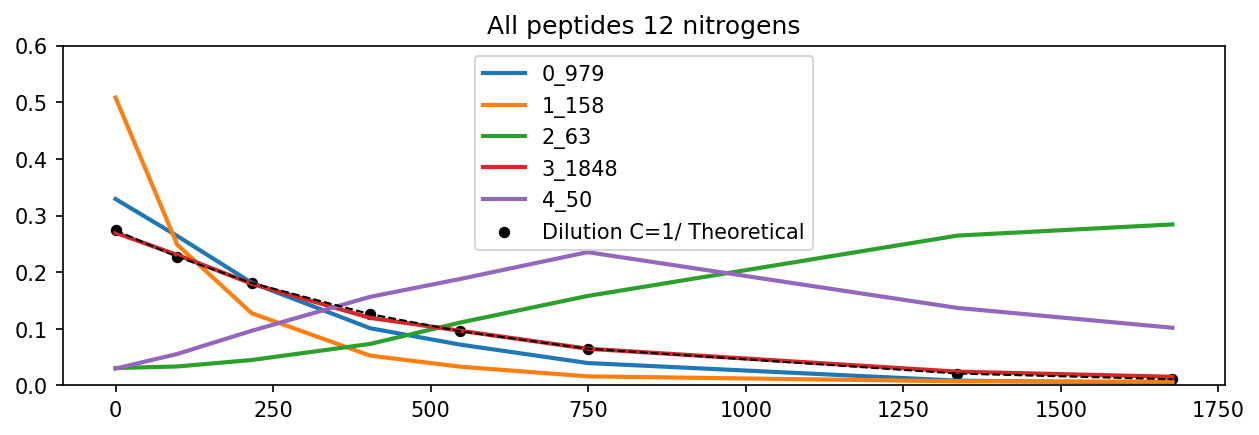

In [15]:
# Check if normalization was actually okay 

plt.figure(figsize=(10,3),dpi=150)

nitrogen_test= 12
temporary=df_final_normalized[df_final_normalized['Nitrogens']==nitrogen_test].dropna(subset= ['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave'])

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']]
kmeans= KMeans(n_clusters=5, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []
i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    cluster_number.append(len(kmeans.labels_[kmeans.labels_==i]))
    
    i=i+1
    
plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution C=1/ Theoretical')
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.6])
plt.title('All peptides %d nitrogens'%(nitrogen_test))
plt.legend()
plt.show()


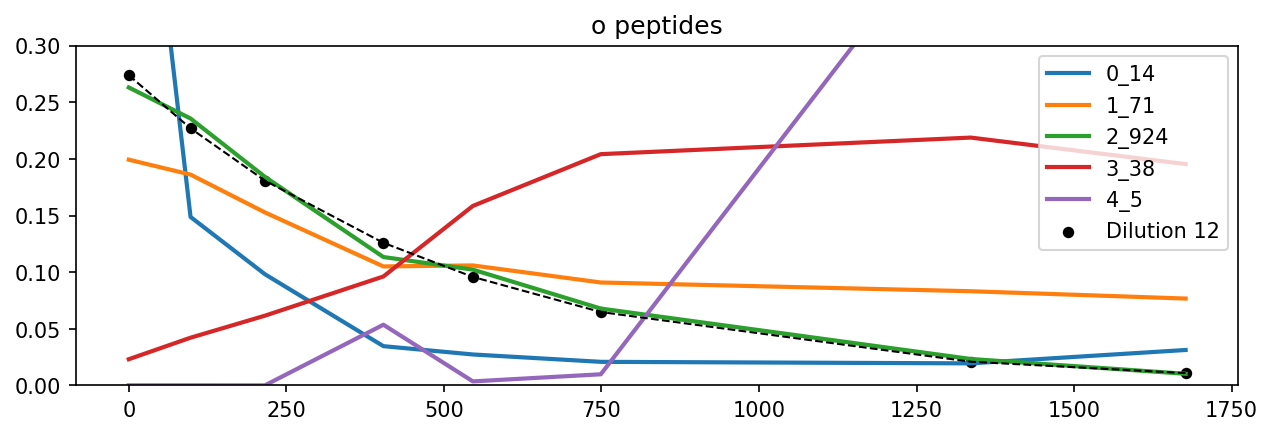

In [16]:
plt.figure(figsize=(10,3),dpi=150)
choice_value='o'

temporary=sub_cellular(choice_value, df_final_normalized).dropna(subset= ['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave'])

X= temporary[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave', '5_med_ave', '6_med_ave', '7_med_ave']]
no_clusters= 5
kmeans= KMeans(n_clusters=no_clusters, copy_x= True, n_init= 50, random_state=50).fit(X)

cluster_number= []
cosine_distance=[]
i=0 
while i< len(kmeans.cluster_centers_): 
    plt.plot(time_array, kmeans.cluster_centers_[i], label ='%d_%d'%(i,kmeans.labels_[kmeans.labels_==i].shape[0]), linewidth=2)
    cluster_number.append(len(kmeans.labels_[kmeans.labels_==i]))
    cosine_distance.append(cosine_distance_calculator(kmeans.cluster_centers_[i]))
    i=i+1

membrane_peptides_kmeans_clusters=pd.DataFrame({'Labels': np.arange(0,no_clusters), 'cluster_number': cluster_number, 'cosine_distance': cosine_distance})
temporary['kmeans_labels']= kmeans.labels_
membrane_peptides_kmeans= temporary

plt.scatter(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  s=20, label='Dilution %d'%(nitrogen_test))
plt.plot(time_array,normalized_array_for_plotting(Dilution_half_life_hrs,0,nitrogen_test),color='black',  ls='--', lw=1)
plt.ylim([0, 0.3])
plt.title('%s peptides'%(choice_value))
plt.legend()
plt.show()

# Fitting the half lives to the curves using the normalized data

In [17]:
grouped_proteins= df_final_normalized.groupby(['Protein ID'])

protein_id= []
half_life=[]
pcov= []
sample_size= []

for name, group in grouped_proteins: 

    df_temp=grouped_proteins.get_group(name)
    df_temp1= df_temp[['0_med_ave', '1_med_ave', '2_med_ave','3_med_ave','4_med_ave','5_med_ave','6_med_ave','7_med_ave']]
    values1= df_temp1.values.flatten()
    time_array1= np.tile(time_array, len(df_temp))
    nitrogens= df_temp['Nitrogens'].values
    n_array= np.repeat(nitrogens,8)
    
    protein_id.append(name)

    try: 
        array1,array2=curve_fit(degradation, (time_array1, n_array), values1, p0=[np.log(2)/Dilution_half_life_hrs/60])
#         print (array2[0][0])
        sample_size.append(len(values1))
        pcov.append(array2[0][0])
        degradation_readjusted_value= array1[0]
        half_life.append(1*np.log(2)/degradation_readjusted_value/60)
    except:
        print (name)
        half_life.append(float('Nan'))
        
        
from scipy.stats.distributions import  t

alpha=0.05

df_final_proteins= pd.DataFrame({'Protein ID': protein_id, 'Half_life_hrs': half_life, 'Cov': pcov, 'sample_size': sample_size})
df_final_proteins['sigma']= df_final_proteins['Cov'].map(lambda x: np.sqrt(x))
df_final_proteins['dof']= df_final_proteins['sample_size'].map(lambda x: x-1 if x>1 else 0)
df_final_proteins['tval']= df_final_proteins['dof'].map(lambda x: t.ppf(1.0-alpha/2., x) )
df_final_proteins['conf_interval_rate_per_min']= df_final_proteins['sigma']*df_final_proteins['tval']

df_final_proteins['Entry']= df_final_proteins['Protein ID'].apply(header_splitter)
df_final_proteins2= df_final_proteins.merge(tmt5_location[['Entry','Gene names ', 'Subcellular location [CC] 1', 'membrane_confirmation']], on='Entry', how='left')
df_final_proteins2.head()

Protein ID  Half_life_hrs           Cov  sample_size     sigma  \
0  sp|P00350|6PGD_ECOLI       5.216711  7.898749e-09          384  0.000089   
1  sp|P00363|FRDA_ECOLI       5.738230  4.103630e-09          232  0.000064   
2  sp|P00370|DHE4_ECOLI       2.047775  1.934165e-08           88  0.000139   
3  sp|P00393|DHNA_ECOLI       7.704508  9.822362e-09          200  0.000099   
4  sp|P00448|SODM_ECOLI       5.819135  3.546110e-09          144  0.000060   

   dof      tval  conf_interval_rate_per_min   Entry Gene names   \
0  383  1.966177                    0.000175  P00350         gnd   
1  231  1.970287                    0.000126  P00363        frdA   
2   87  1.987608                    0.000276  P00370        gdhA   
3  199  1.971957                    0.000195  P00393         ndh   
4  143  1.976692                    0.000118  P00448        sodA   

  Subcellular location [CC] 1 membrane_confirmation  
0                         NaN                 False  
1                         NaN                 False  
2                         NaN                 False  
3              Cell membrane.                 False  
4                         NaN                 False

In [18]:
df_final_proteins2.to_csv('Half_life_%s.csv'%(filename))

# An intermediate check on the values of fitted half lives 

In [19]:
if Dilution_half_life_hrs==12 : 
    limit_value=20 
else: limit_value=10 
    
    
incorrect_proteins1= df_final_proteins2[df_final_proteins2['Half_life_hrs']< 0].shape[0]
incorrect_proteins2= df_final_proteins2[df_final_proteins2['Half_life_hrs']> limit_value].shape[0]
print ('The number of proteins with negative half lives %d, the number with greater than %d half lives is %d' %(incorrect_proteins1, limit_value, incorrect_proteins2))

The number of proteins with negative half lives 26, the number with greater than 10 half lives is 88


# Get the histograms for half life plots 

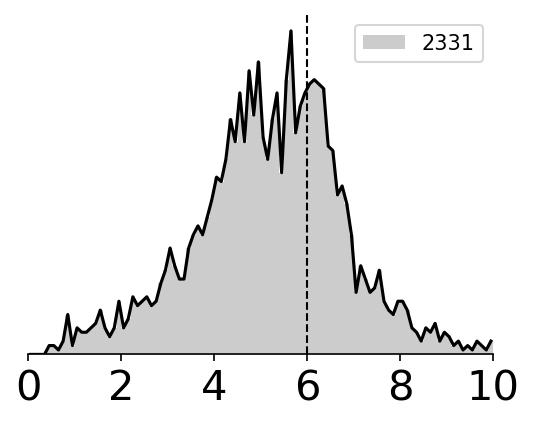

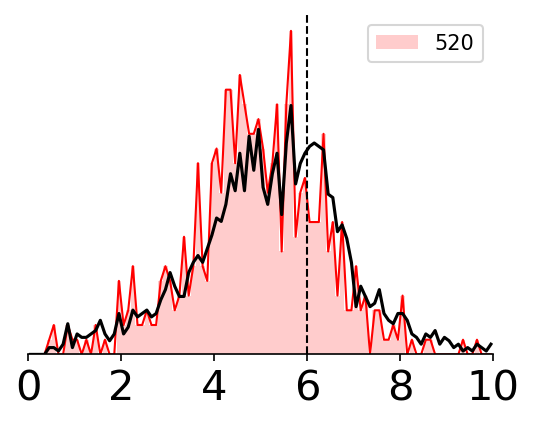

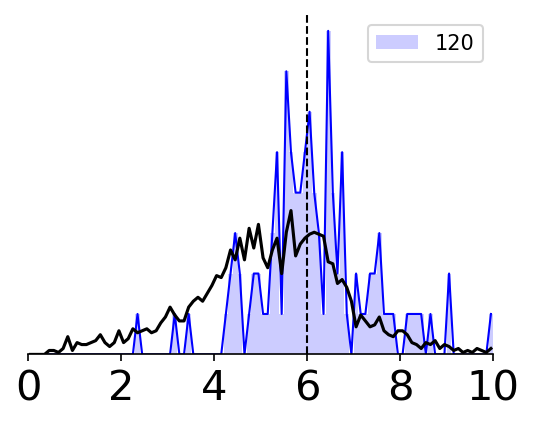

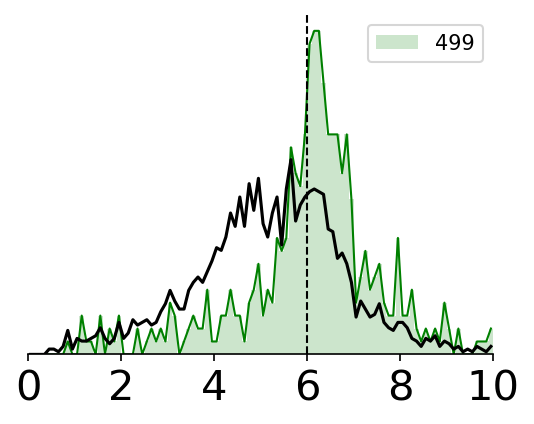

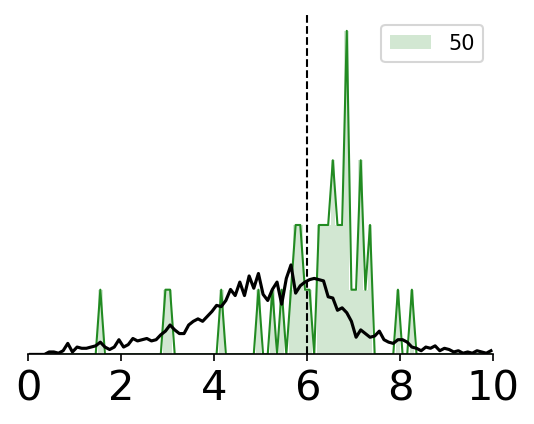

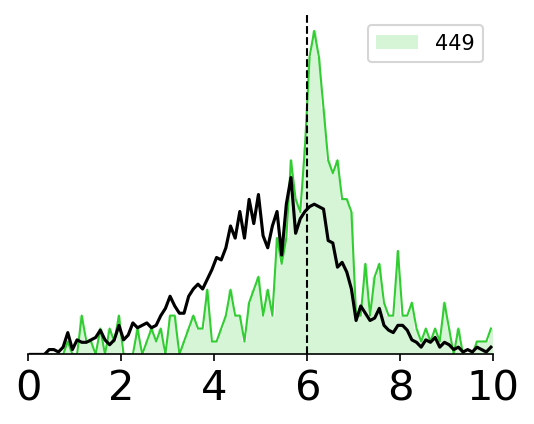

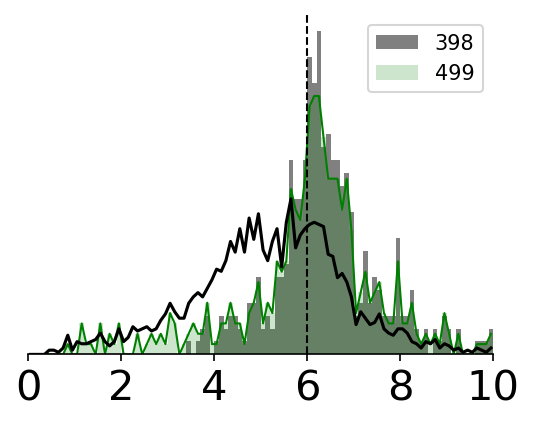

In [20]:
membrane=sub_cellular('m', df_final_proteins2)
cytoplasm= sub_cellular('c', df_final_proteins2)
periplasm= sub_cellular('p', df_final_proteins2)
outer_membrane= sub_cellular('o', df_final_proteins2)
inner_membrane= sub_cellular('i', df_final_proteins2)

membrane_proteins_normalize = pd.DataFrame({'Protein ID': membrane_peptides_for_norm_truncate_nitrogens['Protein ID'].unique()})
membrane_proteins_normalize1= membrane_proteins_normalize.merge(df_final_proteins2, on='Protein ID', how='left')



vertical_line_p=Dilution_half_life_hrs
alpha_value_shade= 0.2
alpha_value_outline= 1
lw_value_global= 1.5
lw_value_compartments= 1
lw_vertical_line_p= 1
color_global='black' 
color_c= 'red'
color_p= 'blue'
color_m= 'green'
color_om= 'forestgreen'
color_im= 'limegreen'

title= '%s'%filename
title_c= 'cytoplasm'
title_m= 'membrane'
title_p= 'periplasm'

plot_value='Half_life_hrs'

    
bins= np.linspace(0,limit_value,101)
array_bins=[]
i=0
while i< len(bins)-1: 
    array_bins.append((bins[i]+bins[i+1])/2) 
    i=i+1
    


# global     
fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a,b,c=plt.hist(df_final_proteins2['Half_life_hrs'], bins, density=True, color=color_global, alpha= alpha_value_shade, label='%d'%(len(df_final_proteins2)))
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,limit_value])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
#plt.savefig('C:\\Users\\mgupta\\Desktop\\Backup\\Research\\Papers\\By me\\Central Dogma\\Data_dump\\rates_hr_%ss.png'%(title))
plt.legend()

# cytoplasm_p     
fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(cytoplasm['Half_life_hrs'], bins, density=True, color=color_c, alpha= alpha_value_shade, label='%d'%(len(cytoplasm)))
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_c, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,limit_value])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
#plt.savefig('C:\\Users\\mgupta\\Desktop\\Backup\\Research\\Papers\\By me\\Central Dogma\\Data_dump\\rates_hr_%ss_%s.png'%(title, title_c))
plt.legend()

# cytoplasm_p     
fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(periplasm['Half_life_hrs'], bins, density=True, color=color_p, alpha= alpha_value_shade,label='%d'%(len(periplasm)))
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_p, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,limit_value])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
#plt.savefig('C:\\Users\\mgupta\\Desktop\\Backup\\Research\\Papers\\By me\\Central Dogma\\Data_dump\\rates_hr_%ss_%s.png'%(title, title_p))
plt.legend()


# cytoplasm_p     
fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(membrane['Half_life_hrs'], bins, density=True, color=color_m, alpha= alpha_value_shade, label= '%d'%(len(membrane)))
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_m, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,limit_value])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
plt.legend()

fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(outer_membrane['Half_life_hrs'], bins, density=True, color=color_om, alpha= alpha_value_shade, label= '%d'%(len(outer_membrane)))
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_om, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,limit_value])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
plt.legend()

fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
a_c,b_c,c_c=plt.hist(inner_membrane['Half_life_hrs'], bins, density=True, color=color_im, alpha= alpha_value_shade, label= '%d'%(len(inner_membrane)))
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_im, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,limit_value])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
plt.legend()
#plt.savefig('C:\\Users\\mgupta\\Desktop\\Backup\\Research\\Papers\\By me\\Central Dogma\\Data_dump\\rates_hr_%ss_%s.png'%(title, title_m))

plt.show()




fig= plt.figure(figsize=(4,3),dpi=150)
ax = fig.add_subplot(111)
plt.hist(membrane_proteins_normalize1['Half_life_hrs'], bins, density=True, color='grey', alpha= 1, label= '%d'%(len(membrane_proteins_normalize1)))
a_c,b_c,c_c=plt.hist(membrane['Half_life_hrs'], bins, density=True, color=color_m, alpha= alpha_value_shade, label= '%d'%(len(membrane)))
plt.plot(array_bins,a_c,lw=lw_value_compartments, color=color_m, alpha=alpha_value_outline, ls='-')
plt.plot(array_bins,a,lw=lw_value_global, color=color_global, alpha=alpha_value_outline, ls='-')
plt.xlim([0,limit_value])
plt.axvline(vertical_line_p, lw=lw_vertical_line_p, ls='--', color='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False)
plt.legend()

In [21]:
Dilution_half_life_hrs

6.0